In [1]:
import os

import sys
import logging
import numpy as np
import pandas as pd
import IPython.display as ipd

import librosa
import librosa.display

In [2]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
if isnotebook():
    sys.path.append(parentdir)
    sys.path.insert(0, parentdir)
else:
    sys.path.insert(0, currentdir)
    print(currentdir)

In [3]:
logging.root.handlers = []
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [4]:
from dataparsing.parsing_functions import DataParsingStrategy
from dataparsing.output_strategies import DataOutputStrategy, convinAIentOutputStrategy
from dataparsing.parsing_strategy_selector import search_suitable_dataparsing_strategy_for_file
from dataparsing import parsing_functions

from anAIlysis import ESA
from anAIlysis import signal_processing as DSP
# from anAIlysis import plotting as eplt
# from anAIlysis import signal_analysis as SA
from anAIlysis import get_samplerate as GSR
from anAIlysis import file_handler as fh

np.random.seed(seed=42)

In [5]:
# Use WebAgg if no display is connected (e.g. ssh) and not running as notebook
import matplotlib
if (os.name == 'posix' and "DISPLAY" not in os.environ) and not isnotebook():
    matplotlib.use('WebAgg')
elif isnotebook():
    try:
        get_ipython().run_line_magic('matplotlib', 'widget')
    except ModuleNotFoundError:
        get_ipython().run_line_magic('matplotlib', 'inline')

# Return used Matplotlib backend
logger.info(f"Matplotlib backend: {matplotlib.get_backend()}")

import matplotlib.pyplot as plt

INFO:__main__:Matplotlib backend: module://ipympl.backend_nbagg


 ## 3-Phase Current Sine Wave

In [6]:
model = pd.DataFrame(columns=['amplitude', 'frequency', 'theta', 'offset', 'fs', 'length', 'time', 'signal', 'noise', 'signal_noise'])

for i in range(0, 3):
    model.at[i, 'amplitude'] = 1 + np.random.random_sample()
    model.at[i, 'frequency'] = 50
    model.at[i, 'theta'] = i * 2 * np.pi / 3.0 + np.random.random_sample()
    model.at[i, 'offset'] = 0 + np.random.random_sample()
    model.at[i, 'fs'] = 10e3
    model.at[i, 'length'] = 10 # in seconds
    model.at[i, 'time'] = np.arange(0, model.at[i, 'length'], 1 / model.at[i, 'fs'])
    model.at[i, 'signal'] = model.at[i, 'amplitude'] * np.sin(2 * np.pi * model.at[i, 'frequency'] * model.at[i, 'time'] + model.at[i, 'theta'])
    
    model.at[i, 'mu'] = 0
    model.at[i, 'sigma'] = 0.1
    model.at[i, 'noise'] = np.random.normal(model.at[i, 'mu'], model.at[i, 'sigma'], len(model.at[i, 'signal']))
    model.at[i, 'signal_noise'] = model.at[i, 'signal'] + model.at[i, 'noise']

Text(0, 0.5, 'Amplitude = sin(time)')

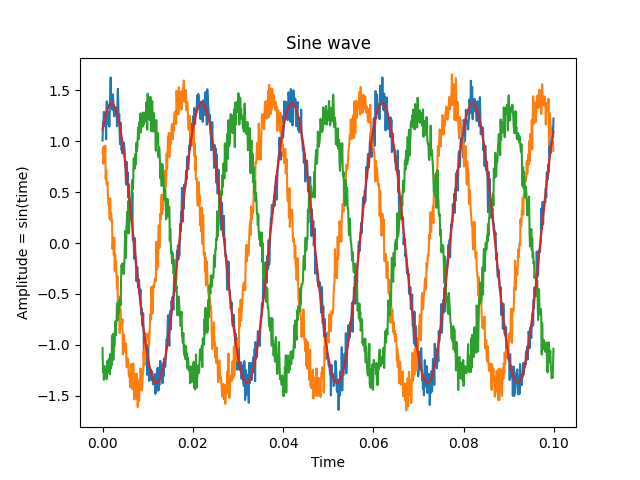

In [7]:
length_plot = int(0.1 * model.at[0, 'fs'])

fig, ax = plt.subplots()

for i in range(0, 3):
    ax.plot(model.at[i, 'time'][0:length_plot], model.at[i, 'signal_noise'][0:length_plot])

ax.plot(model.at[0, 'time'][0:length_plot], model.at[0, 'signal'][0:length_plot])
ax.set_title('Sine wave')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude = sin(time)')

 ## DQ-Transformation

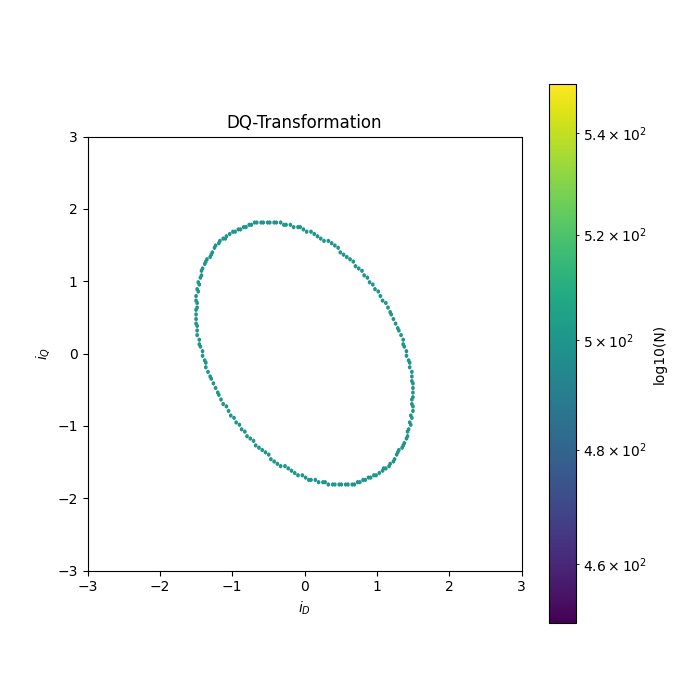

In [8]:
i_a = model.at[0, 'amplitude'] * np.sin(2 * np.pi * model.at[0, 'frequency'] * model.at[0, 'time'] + 0 * model.at[1, 'theta'])
i_b = model.at[0, 'amplitude'] * np.sin(2 * np.pi * model.at[0, 'frequency'] * model.at[0, 'time'] + 1 * model.at[1, 'theta'])
i_c = model.at[0, 'amplitude'] * np.sin(2 * np.pi * model.at[0, 'frequency'] * model.at[0, 'time'] + 2 * model.at[1, 'theta'])

i_d, i_q = ESA.dq(i_a, i_b, i_c)

lim = 3

fig, ax = plt.subplots(figsize=(7,7))
hb = ax.hexbin(i_d, i_q, bins='log')
# plt.legend(loc="upper left")
plt.xlabel(r'$i_D$')
plt.ylabel(r'$i_Q$')
ax.set(xlim=(-lim,lim), ylim=(-lim,lim))
ax.set_aspect('equal', 'box')
ax.set_title(f"DQ-Transformation")
cb = fig.colorbar(hb, ax=ax, label='log10(N)')

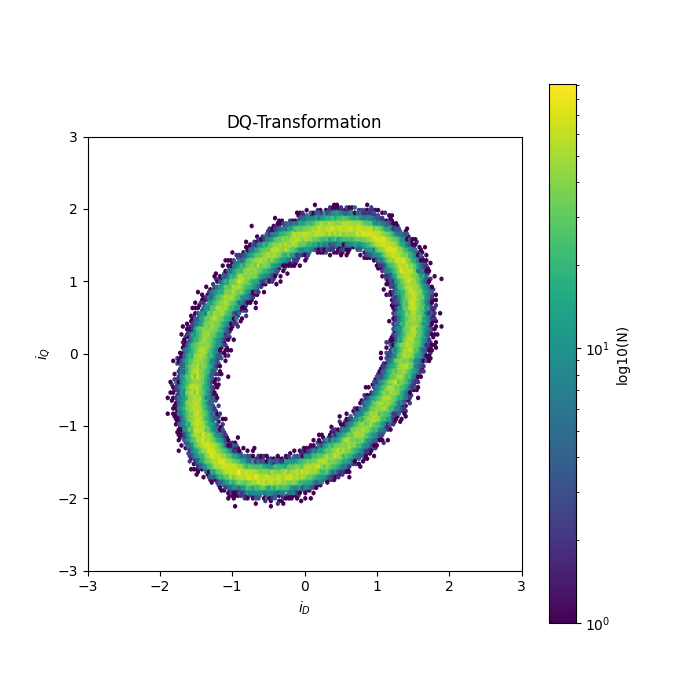

In [9]:
i_d, i_q = ESA.dq(model.at[0, 'signal_noise'], model.at[1, 'signal_noise'], model.at[2, 'signal_noise'])

lim = 3

fig, ax = plt.subplots(figsize=(7,7))
hb = ax.hexbin(i_d, i_q, bins='log')
# plt.legend(loc="upper left")
plt.xlabel(r'$i_D$')
plt.ylabel(r'$i_Q$')
ax.set(xlim=(-lim,lim), ylim=(-lim,lim))
ax.set_aspect('equal', 'box')
ax.set_title(f"DQ-Transformation")
cb = fig.colorbar(hb, ax=ax, label='log10(N)')

 ## Motor Current Signature Analysis (MCSA)

Text(0.5, 1.0, 'Motor Current Signature Analysis')

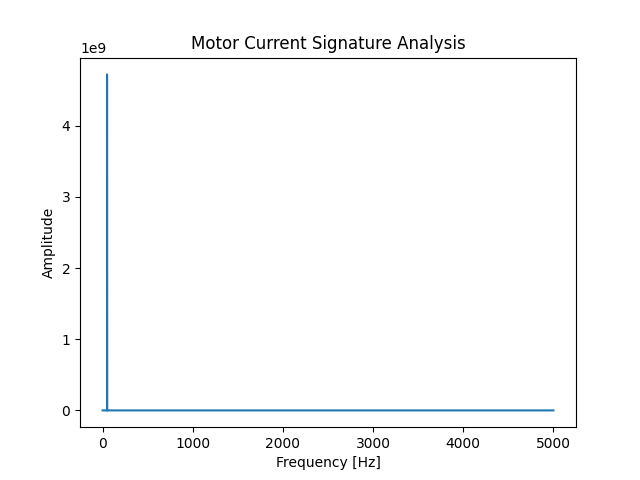

In [10]:
signal = model.at[0, 'signal_noise']
fs = model.at[0, 'fs']

freq, fft = ESA.csa(signal, fs=fs)

fig, ax = plt.subplots()
ax.plot(freq, fft)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Amplitude')
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
ax.set_title(f"Motor Current Signature Analysis")

 ## Enhanced Park's Vector Approach (EPVA)

Text(0.5, 1.0, "Enhanced Park's Vector Approach")

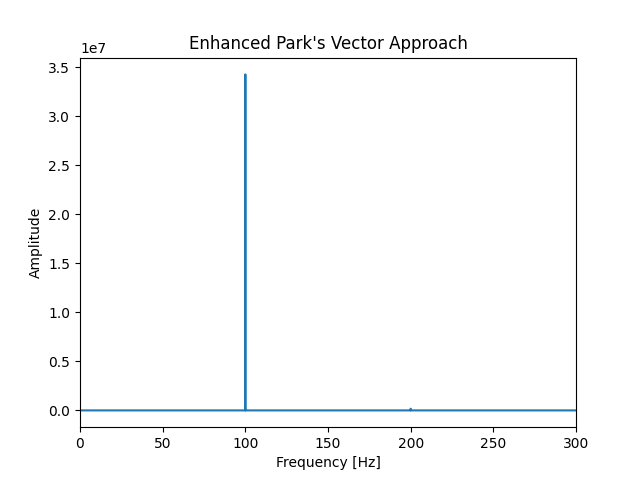

In [11]:
signal = model.at[0, 'signal_noise']
fs = model.at[0, 'fs']

freq, fft = ESA.epva(i_d, i_q, fs=fs)

fig, ax = plt.subplots()
ax.plot(freq, fft)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Amplitude')
ax.set_xlim((0, 3e2))
# ax.set_ylim(ylim)
ax.set_title(f"Enhanced Park's Vector Approach")

 ## PicoScope Data Imports

In [12]:
import pandas as pd

data_path = 'data/SINUS.csv'

data_path = os.path.join(parentdir, data_path) if isnotebook() else data_path

data_df = pd.read_csv(data_path, index_col=0, header=[0, 1], sep=';', decimal=",")

Text(0, 0.5, 'Amplitude (V)')

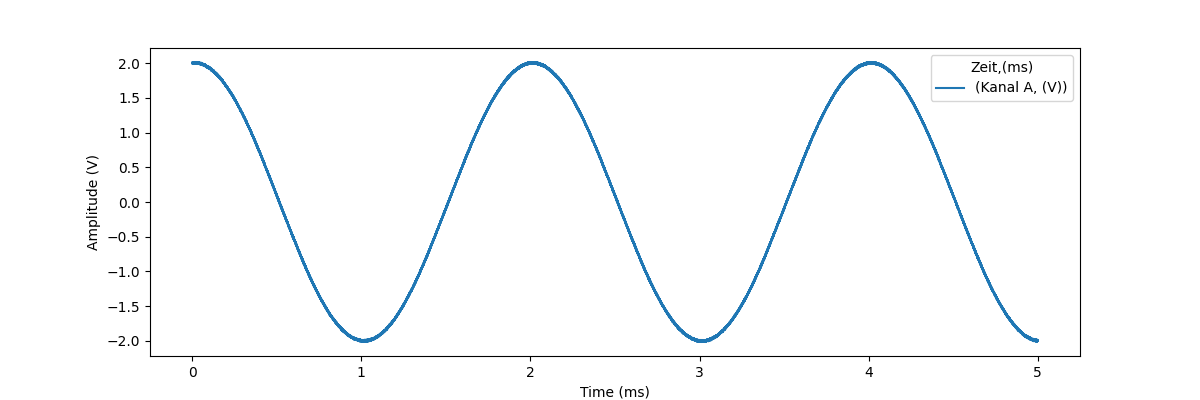

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
data_df.plot(ax=ax)
ax.set_xlabel('Time %s' % data_df.columns.names[1])
ax.set_ylabel('Amplitude %s' % data_df.columns[0][1])

In [14]:
channels = data_df.columns.get_level_values(0).unique()
amplitude = data_df[channels[0]].values